In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

### Data

In [4]:
def load_data(train_path, test_path, sub_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    sub = pd.read_csv(sub_path)

    # print(train.info())
    # print(test.info())

    return train, test, sub

train, test, sub = load_data('/content/Train.csv', '/content/Test.csv', '/content/SampleSubmission.csv')

In [5]:
train.head(3)

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,P5DA,RIBP,8NN1,7POT,66FJ,GYSR,SOP4,RVSZ,PYUQ,LJR9,N2MW,AHXO,BSTQ,FM3X,K6QO,QBOL,JWFN,JZ9D,J9JW,GHYX,ECY3
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1


## Preprocessing

In [6]:
products = train.columns[8:]
n_train = pd.melt(train, id_vars=train.columns[:8], value_vars=products)
n_test = pd.melt(test, id_vars=test.columns[:8], value_vars=products)
n_train.head()

,ID,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,variable,value
0,4WKQSBB,1/2/2019,F,M,1987,1X1H,2A7I,T4MS,P5DA,0
1,CP5S02H,1/6/2019,F,M,1981,UAOD,2A7I,T4MS,P5DA,0
2,2YKDILJ,1/6/2013,M,U,1991,748L,QZYX,90QI,P5DA,0
3,2S9E81J,1/8/2019,M,M,1990,1X1H,BP09,56SI,P5DA,0
4,BHDYVFT,1/8/2019,M,M,1990,748L,NO3L,T4MS,P5DA,0


In [7]:
features = pd.concat([n_train, n_test])
features.rename(columns={'variable':'product','value':'Label'}, inplace=True)
features['ID X PCODE'] = features['ID'] + ' X ' + features['product']
features = features.drop(['ID'], axis = 1)
features.tail(3)

,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,product,Label,ID X PCODE
209997,1/4/2018,M,M,1993,748L,SST3,56SI,ECY3,0,42WTEGT X ECY3
209998,1/5/2015,F,U,1981,49BM,2A7I,T4MS,ECY3,0,8EKC4O9 X ECY3
209999,1/11/2018,M,U,1977,94KC,2A7I,T4MS,ECY3,0,WHII93K X ECY3


### Null values

In [9]:
features.isna().sum()

join_date                   63
sex                          0
marital_status               0
birth_year                   0
branch_code                  0
occupation_code              0
occupation_category_code     0
product                      0
Label                        0
ID X PCODE                   0
dtype: int64

In [11]:
imputer = SimpleImputer(strategy = 'most_frequent')
x = features['join_date'].values
x = x.reshape(-1,1)
features['join_date'] = imputer.fit_transform(x)
features.isna().sum()

join_date                   0
sex                         0
marital_status              0
birth_year                  0
branch_code                 0
occupation_code             0
occupation_category_code    0
product                     0
Label                       0
ID X PCODE                  0
dtype: int64

In [12]:
features_back = features.copy()

### Categorical cols encoding

In [13]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
cat_df = features[['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code', 'product']]
cat_df = cat_df.apply(LabelEncoder().fit_transform)
cat_df.head()

# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# cat_df = features[['product']]
# cat_df = cat_df.apply(LabelEncoder().fit_transform)
# cat_df.head()

,sex,marital_status,branch_code,occupation_code,occupation_category_code,product
0,0,2,0,19,5,15
1,0,2,11,19,5,15
2,1,6,3,185,1,15
3,1,2,0,82,0,15
4,1,2,3,157,5,15


In [14]:
features['sex'] = cat_df['sex']
features['marital_status'] = cat_df['marital_status']
features['branch_code'] = cat_df['branch_code']
features['occupation_code'] = cat_df['occupation_code']
features['occupation_category_code'] = cat_df['occupation_category_code']
features['product'] = cat_df['product']
features.head(3)

,join_date,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,product,Label,ID X PCODE
0,1/2/2019,0,2,1987,0,19,5,15,0,4WKQSBB X P5DA
1,1/6/2019,0,2,1981,11,19,5,15,0,CP5S02H X P5DA
2,1/6/2013,1,6,1991,3,185,1,15,0,2YKDILJ X P5DA


In [ ]:
# features = pd.get_dummies(features, columns = ['sex', 'marital_status', 'branch_code', 'occupation_code', 'occupation_category_code'], drop_first=True)

### Feature Generation

In [15]:
features['join_date'] = pd.to_datetime(features['join_date'])
# features['birth_year'] = pd.to_datetime(features['birth_year'])

features['Month'] = features.join_date.dt.month.to_list()
features['Year'] = features.join_date.dt.year.to_list()
features['Day'] = features.join_date.dt.day.to_list()
features['DayOfWeek'] = features.join_date.dt.dayofweek.to_list()

features['yrs_spent'] = 2020 - features['Year']
features['age'] = features['Year'] - features['birth_year']
features = features.drop(['join_date'], axis = 1)



# features['year_bins'] = pd.qcut(features['Year'], 5, labels = False)
features.head()

## add number of yrs spent (now - join date)

,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,product,Label,ID X PCODE,Month,Year,Day,DayOfWeek,yrs_spent,age
0,0,2,1987,0,19,5,15,0,4WKQSBB X P5DA,1,2019,2,2,1,32
1,0,2,1981,11,19,5,15,0,CP5S02H X P5DA,1,2019,6,6,1,38
2,1,6,1991,3,185,1,15,0,2YKDILJ X P5DA,1,2013,6,6,7,22
3,1,2,1990,0,82,0,15,0,2S9E81J X P5DA,1,2019,8,1,1,29
4,1,2,1990,3,157,5,15,0,BHDYVFT X P5DA,1,2019,8,1,1,29


### Scaling Numerical Features

In [16]:
from sklearn.preprocessing import StandardScaler

indices = [2, 9,10,11,12,13]
# indices = [-1,-2,-3,-4,-5,0]
for col in indices:
    x = features.iloc[:, col].values
    x = x.reshape(-1,1)
    imputer = StandardScaler()
    imputer = imputer.fit(x)
    x = imputer.transform(x)
    features.iloc[:, col] = x 

features.head()

,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,product,Label,ID X PCODE,Month,Year,Day,DayOfWeek,yrs_spent,age
0,0,2,0.798014,0,19,5,15,0,4WKQSBB X P5DA,-0.016615,0.667606,-1.305881,-0.543796,-0.667606,32
1,0,2,0.154357,11,19,5,15,0,CP5S02H X P5DA,-0.016615,0.667606,-0.106598,1.600268,-0.667606,38
2,1,6,1.227118,3,185,1,15,0,2YKDILJ X P5DA,-0.016615,-2.459298,-0.106598,1.600268,2.459298,22
3,1,2,1.119842,0,82,0,15,0,2S9E81J X P5DA,-0.016615,0.667606,0.493043,-1.079813,-0.667606,29
4,1,2,1.119842,3,157,5,15,0,BHDYVFT X P5DA,-0.016615,0.667606,0.493043,-1.079813,-0.667606,29


In [22]:
features['day_bins'] = pd.qcut(features['Day'], 4, labels = False)
features.head()

,sex,marital_status,birth_year,branch_code,occupation_code,occupation_category_code,product,Label,ID X PCODE,Month,Year,Day,DayOfWeek,yrs_spent,age,day_bins
0,0,2,0.798014,0,19,5,15,0,4WKQSBB X P5DA,-0.016615,0.667606,-1.305881,-0.543796,-0.667606,32,0
1,0,2,0.154357,11,19,5,15,0,CP5S02H X P5DA,-0.016615,0.667606,-0.106598,1.600268,-0.667606,38,1
2,1,6,1.227118,3,185,1,15,0,2YKDILJ X P5DA,-0.016615,-2.459298,-0.106598,1.600268,2.459298,22,1
3,1,2,1.119842,0,82,0,15,0,2S9E81J X P5DA,-0.016615,0.667606,0.493043,-1.079813,-0.667606,29,2
4,1,2,1.119842,3,157,5,15,0,BHDYVFT X P5DA,-0.016615,0.667606,0.493043,-1.079813,-0.667606,29,2


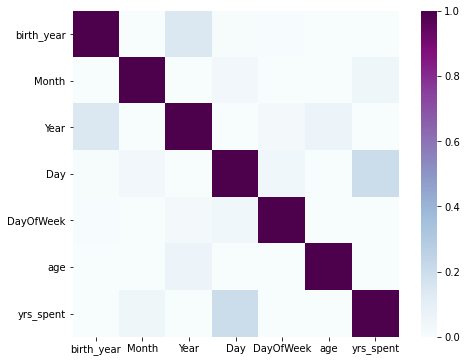

In [23]:
corr_data = features[['birth_year', 'Month', 'Year', 'Day', 'DayOfWeek', 'age', 'yrs_spent']]
corr = corr_data.corr()
f_fig, f_ax = plt.subplots(figsize=(8, 6))
f_ax = sns.heatmap(corr, vmin=0, vmax=1, square=True,
                   annot=False, annot_kws={"size": 10}, cmap="BuPu")

No multicolinearity alarms.

## Modeling

In [86]:
# reconstruct train and test sets
train_feat = features.iloc[:len(n_train)]
test_feat = features.iloc[len(n_train):]
print('before concatenation + preprocesing:' ,n_train.shape, n_test.shape)
print('after concatenation + preprocessing:', train_feat.shape, test_feat.shape)

before concatenation + preprocesing: (611772, 10) (210000, 10)
after concatenation + preprocessing: (611772, 16) (210000, 16)


In [87]:
x_train = train_feat.drop(['Label', 'ID X PCODE'], axis = 1)
y_train = train_feat[['Label']]
x_test = test_feat.drop(['Label', 'ID X PCODE'], axis = 1)
x_train.shape, y_train.shape, x_test.shape, sub.shape

((611772, 14), (611772, 1), (210000, 14), (210000, 2))

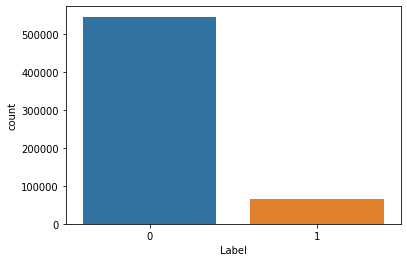

In [29]:
# class imbalance
sns.countplot(train_feat['Label'])

In [30]:
import imblearn

# Tomek links (under sampling)
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl = tl.fit_resample(x_train, y_train)
print(X_tl.shape)
print('Removed indexes:', id_tl)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

(590080, 14)
Removed indexes: [     0      1      2 ... 611769 611770 611771]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# # Repeated nearest neighbor undersampling
# from imblearn.under_sampling import RepeatedEditedNearestNeighbours
# rnn = RepeatedEditedNearestNeighbours()
# X_rnn, y_rnn = rnn.fit_resample(x_train, y_train)
# print(X_rnn.shape)

In [31]:
# Smote oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(ratio='minority')
X_smote, y_smote = smote.fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [34]:
x_train.shape, y_train.shape, X_tl.shape, X_smote.shape, y_tl.shape, y_smote.shape

((611772, 14), (611772, 1), (590080, 14), (1090838, 14), (590080,), (1090838,))

Text(0.5, 1.0, 'Tomek link undersampling')

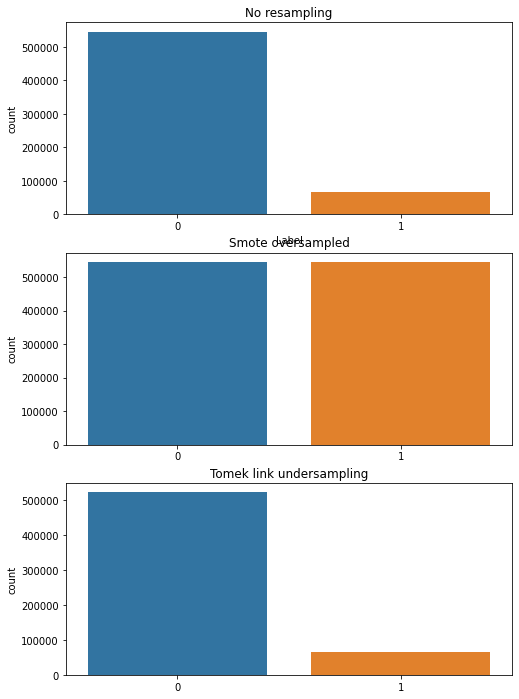

In [49]:
f, axs = plt.subplots(3,figsize=(8,12))
sns.countplot(y_train.Label, ax = axs[0]).set_title('No resampling')
sns.countplot(y_smote, ax = axs[1]).set_title('Smote oversampled')
sns.countplot(y_tl, ax = axs[2]).set_title('Tomek link undersampling')
# sns.countplot(y_cnn, ax = axs[2]).set_title('RNN undersampling')

In [62]:
# models + accuracy metrics
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from lightgbm import LGBMClassifier


# evaluation
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
from sklearn.metrics import precision_recall_fscore_support as score

     |████████████████████████████████| 66.1MB 58kB/s 


In [69]:
# kfold
kf = KFold(n_splits=10, random_state = 42, shuffle = True)
def overall_score(model, x_train, y_train):
    accuracy = cross_val_score(estimator = model, X = x_train, y = y_train, cv = kf)
    return accuracy.mean()

#stratified
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle = True)
def overall__stratified_score(model, x_train, y_train):
    accuracy = cross_val_score(estimator = model, X = x_train, y = y_train, cv = cv)
    return accuracy.mean()

In [ ]:
# def rmsle_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
#     rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

In [61]:
# import lightgbm as lgb
# from sklearn.metrics import log_loss

# l_dat = lgb.Dataset(x_train, y_train)

# params = {
#         'objective': 'xentropy',
#         'learning_rate':0.05,
#         'reg_lambda': 1,
#         'feature_fraction': 0.75,
#         'bagging_fraction': 0.7,
#         'bagging_freq': 1,
#         'boosting_type': 'gbdt',
#         'reg_alpha': 2,
#         'num_leaves':  31,
#         'min_data_in_leaf': 1,
#         'feature_fraction_seed': 201,
#         'bagging_seed': 427
#         }

# cv = lgb.cv(params, l_dat, num_boost_round = 5)

# # Display results
# print('Current parameters:\n', params)
# # print('\nBest num_boost_round:', len(cv['l1-mean']))
# # print('Best CV score:', cv['l1-mean'][-1])
# cv

Current parameters:
 {'objective': 'xentropy', 'learning_rate': 0.05, 'reg_lambda': 1, 'feature_fraction': 0.75, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'boosting_type': 'gbdt', 'reg_alpha': 2, 'num_leaves': 31, 'min_data_in_leaf': 1, 'feature_fraction_seed': 201, 'bagging_seed': 427}


{'xentropy-mean': [0.6566705986693567,
  0.6238390372862279,
  0.5934914541932385,
  0.5659661459922546,
  0.5514559201242776],
 'xentropy-stdv': [0.0002925837774641566,
  0.0003166111897807529,
  0.00015821798738805857,
  0.00042297730965888306,
  0.00041024237388265894]}

In [ ]:
# using ridsearch to get the optimal parameters
# lgbm = LGBMClassifier(colsample_bytree = 0.9234, min_child_samples = 399, 
#                   min_child_weight = 0.1, num_leaves = 13, 
#                   reg_alpha = 2, reg_lambda = 5, subsample = 0.855)

lgbm = LGBMClassifier()

optimization_dict = {
    'num_leaves': [40, 120],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [50, 100, 300],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

model = GridSearchCV(lgbm, optimization_dict, 
                     scoring='accuracy', verbose=1)


model.fit(x_train,y_train.ravel())
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 36.9min finished


0.9651955950281618
{'lambda_l1': 0, 'lambda_l2': 1, 'min_data_in_leaf': 50, 'num_leaves': 120, 'reg_alpha': 0.1}


In [70]:
lgbm = LGBMClassifier(lambda_l1 = 0, lambda_l2 = 1, min_data_in_leaf = 50, num_leaves = 120, reg_alpha = 0.1)

# using kfolds
print('lgbm mean score smote stratified:', overall__stratified_score(lgbm, X_smote, y_smote))
print('lgbm mean score smote:', overall_score(lgbm, X_smote, y_smote))
print('lgbm mean score links stratified:', overall__stratified_score(lgbm, X_tl, y_tl))
print('lgbm mean score links:', overall_score(lgbm, X_tl, y_tl))
yy = y_train.values.ravel()
print('lgbm mean score org stratified:', overall__stratified_score(lgbm, x_train, yy))
print('lgbm mean score org:', overall_score(lgbm, x_train, yy))


lgbm mean score smote stratified: 0.9770268357779006
lgbm mean score smote: 0.977021335345506
lgbm mean score links stratified: 0.963420214208243
lgbm mean score links: 0.9634286876355749
lgbm mean score org stratified: 0.9626282353128509
lgbm mean score org: 0.9626282346716003


In [78]:
from sklearn.metrics import confusion_matrix
x_train, x_val, y_train, y_val = train_test_split(x_train ,y_train, test_size = 0.20, random_state = 42)
lgbm = lgbm.fit(x_train, y_train)
y_pred = lgbm.predict_proba(x_val)
loss = log_loss(y_val, y_pred)
print('org loss:', loss)
cm = confusion_matrix(y_val, lgbm.predict(x_val))
print('org cm:\n', cm)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


org loss: 0.10511024311447192
org cm:
 [[107532   1521]
 [  3076  10226]]


In [79]:
x_train, x_val, y_train, y_val = train_test_split(X_smote ,y_smote, test_size = 0.20, random_state = 42)
lgbm = lgbm.fit(x_train, y_train)
y_pred = lgbm.predict_proba(x_val)
loss = log_loss(y_val, y_pred)
print('smote loss:', loss)
cm = confusion_matrix(y_val, lgbm.predict(x_val))
print('smote cm\n:', cm)

smote loss: 0.06769950313805935
smote cm
: [[107374   1816]
 [  3118 105860]]


In [80]:
x_train, x_val, y_train, y_val = train_test_split(X_tl ,y_tl, test_size = 0.20, random_state = 42)
lgbm = lgbm.fit(x_train, y_train)
y_pred = lgbm.predict_proba(x_val)
loss = log_loss(y_val, y_pred)
print('Tomek link loss:', loss)
cm = confusion_matrix(y_val, lgbm.predict(x_val))
print('Tomek link cm:\n', cm)

Tomek link loss: 0.10528479326576251
Tomek link cm:
 [[103185   1397]
 [  3001  10433]]


All through smote gives me a good pred. Lets see cat boost

In [ ]:
cat = CatBoostClassifier(silent = True)

print('cat mean score smote stratified:', overall__stratified_score(cat, X_smote, y_smote))
print('cat mean score smote:', overall_score(cat, X_smote, y_smote))
print('cat mean score links stratified:', overall__stratified_score(cat, X_tl, y_tl))
print('cat mean score links:', overall_score(cat, X_tl, y_tl))
yy = y_train.values.ravel()
print('cat mean score org stratified:', overall__stratified_score(cat, x_train, yy))
print('cat mean score org:', overall_score(cat, x_train, yy))

In [83]:
cat = CatBoostClassifier(silent = True)

x_train, x_val, y_train, y_val = train_test_split(x_train ,y_train, test_size = 0.20, random_state = 42)
cat = cat.fit(x_train, y_train)
y_pred = cat.predict_proba(x_val)
loss = log_loss(y_val, y_pred)
print('org cat loss:', loss)
cm = confusion_matrix(y_val, cat.predict(x_val))
print('org cat cm:\n', cm)

org cat loss: 0.10609933170979258
org cat cm:
 [[107472   1581]
 [  2990  10312]]


In [84]:
x_train, x_val, y_train, y_val = train_test_split(X_smote ,y_smote, test_size = 0.20, random_state = 42)
cat = cat.fit(x_train, y_train)
y_pred = cat.predict_proba(x_val)
loss = log_loss(y_val, y_pred)
print('smote cat loss:', loss)
cm = confusion_matrix(y_val, cat.predict(x_val))
print('smote cat cm:\n', cm)

smote cat loss: 0.06199678502742284
smote cat cm:
 [[107481   1709]
 [  3005 105973]]


In [85]:
x_train, x_val, y_train, y_val = train_test_split(X_tl ,y_tl, test_size = 0.20, random_state = 42)
cat = cat.fit(x_train, y_train)
y_pred = cat.predict_proba(x_val)
loss = log_loss(y_val, y_pred)
print('Tomek link cat loss:', loss)
cm = confusion_matrix(y_val, cat.predict(x_val))
print('Tomek link cat cm:\n', cm)

Tomek link cat loss: 0.10627723310986271
Tomek link cat cm:
 [[103078   1504]
 [  2961  10473]]


Smote wins again.

In [88]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()

x_train, x_val, y_train, y_val = train_test_split(x_train ,y_train, test_size = 0.20, random_state = 42)
mlp = mlp.fit(x_train, y_train)
y_pred = mlp.predict_proba(x_val)
loss = log_loss(y_val, y_pred)
print('org mlp loss:', loss)
cm = confusion_matrix(y_val, mlp.predict(x_val))
print('org mlp cm:\n', cm)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


org mlp loss: 0.15024375351447392
org mlp cm:
 [[107420   1633]
 [  4007   9295]]


In [89]:
x_train, x_val, y_train, y_val = train_test_split(X_smote ,y_smote, test_size = 0.20, random_state = 42)
mlp = mlp.fit(x_train, y_train)
y_pred = mlp.predict_proba(x_val)
loss = log_loss(y_val, y_pred)
print('smote mlp loss:', loss)
cm = confusion_matrix(y_val, mlp.predict(x_val))
print('smote mlp cm:\n', cm)

smote mlp loss: 0.22396891676914793
smote mlp cm:
 [[103250   5940]
 [ 12720  96258]]


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_tl ,y_tl, test_size = 0.20, random_state = 42)
mlp = mlp.fit(x_train, y_train)
y_pred = mlp.predict_proba(x_val)
loss = log_loss(y_val, y_pred)
print('Tomek link mlp loss:', loss)
cm = confusion_matrix(y_val, mlp.predict(x_val))
print('Tomek link mlp cm:\n', cm)

In [ ]:
xgb = XGBClassifier(silent = True)

# using kfolds
print('xgb mean score on the original dataset (kfold):', overall_score(xgb, x_train))

# stratified KFold
print('xgb mean score on the original dataset (stratified kfold):', overall__stratified_score(xgb, x_train))

xgb mean score on the original dataset (kfold): 0.8383664717495843
xgb mean score on the original dataset (stratified kfold): 0.7252857538156843


Interesting

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, x_train, y_train):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(x_train, y_train)

        return self
    
    #Now we do the predictions for cloned models and pick out the mode
    def predict(self, x_train):
        predictions = np.column_stack([
            model.predict(x_train) for model in self.models_
        ])
        m = stats.mode(predictions, axis=1)
        return m[0]

In [ ]:
averaged_models = AveragingModels(models = (lgbm, xgb))

# using kfolds
print('averaged_models mean score on the original dataset (kfold):', overall_score(averaged_models, x_train))
# stratified KFold
print('averaged_models mean score on the original dataset (stratified kfold):', overall__stratified_score(averaged_models, x_train))

In [ ]:
X_smote.shape, x_test.shape

In [ ]:
# lgbm predictions
lgbm = LGBMClassifier(lambda_l1 = 0, lambda_l2 = 1, min_data_in_leaf = 50, num_leaves = 120, reg_alpha = 0.1)

# opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 
#                   'min_child_weight': 0.1, 'num_leaves': 13, 
#                   'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

# lgbm = LGBMClassifier(colsample_bytree = 0.9234, min_child_samples = 399, 
#                   min_child_weight = 0.1, num_leaves = 13, 
#                   reg_alpha = 2, reg_lambda = 5, subsample = 0.855)
#set optimal parameters
# lgbm

lgbm = lgbm.fit(X_smote,y_smote)
l_pred = lgbm.predict(x_test)
l_prob = lgbm.predict_proba(x_test)
l_prob[:5]

array([[0.99533091, 0.00466909],
       [0.99764423, 0.00235577],
       [0.99655359, 0.00344641],
       [0.99734205, 0.00265795],
       [0.9971516 , 0.0028484 ]])

In [ ]:
y_test = pd.DataFrame(l_prob)
# le = LabelEncoder()
# le.fit(y_train.values.ravel())
# y_test.columns = le.inverse_transform(y_test.columns)
y_test.columns = ['label0', 'label1']
y_test.head()

,label0,label1
0,0.995331,0.004669
1,0.997644,0.002356
2,0.996554,0.003446
3,0.997342,0.002658
4,0.997152,0.002848


In [ ]:
# cat = cat.fit(X_smote,y_smote)
# c_pred = cat.predict(x_test)
# c_prob = cat.predict_proba(x_test)
# c_prob[:5]

In [ ]:
y_test = pd.DataFrame(c_prob)
y_test.columns = ['label0', 'label1']
y_test.head()

In [ ]:
sub_prob = pd.DataFrame(columns = ['ID X PCODE', 'Label'])
sub_prob['Label'] = y_test['label1']
sub_prob['ID X PCODE'] = test_feat['ID X PCODE']
sub_prob.tail()

,ID X PCODE,Label
209995,0GMU5UH X ECY3,0.012843
209996,I9W11CD X ECY3,0.015068
209997,42WTEGT X ECY3,0.003180
209998,8EKC4O9 X ECY3,0.023040
209999,WHII93K X ECY3,0.037329


In [ ]:
r = sub.loc[sub['Label'] == 1]
true_list = r['ID X PCODE'].to_list()
len(true_list)

12853

In [ ]:
for i in range(sub_prob.shape[0]):
    if sub_prob['ID X PCODE'].iloc[i] in true_list:
        sub_prob['Label'].iloc[i] = 1.0
        
sub_prob['Label'].nunique()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


183831

In [ ]:
# a = id_df['ID X PCODE'].to_list()
# b = sub_prob['ID X PCODE'].to_list()
# main_list = np.setdiff1d(b,a)
# main_list
# # id_df.shape, sub.shape, sub_prob.shape

In [ ]:
sub_prob.to_csv('damn1.csv', index = False)

In [ ]:
x_train.head(3)

,birth_year,product,sex_F,sex_M,marital_status_D,marital_status_F,marital_status_M,marital_status_P,marital_status_R,marital_status_S,marital_status_U,marital_status_W,marital_status_f,branch_code_1X1H,branch_code_30H5,branch_code_49BM,branch_code_748L,branch_code_94KC,branch_code_9F9T,branch_code_BOAS,branch_code_E5SW,branch_code_EU3L,branch_code_O4JC,branch_code_O67J,branch_code_UAOD,branch_code_X23B,branch_code_XX25,branch_code_ZFER,occupation_code_00MO,occupation_code_0B60,occupation_code_0FOI,occupation_code_0KID,occupation_code_0OJM,occupation_code_0PO7,occupation_code_0S50,occupation_code_0SH6,occupation_code_0VYC,occupation_code_0ZND,occupation_code_1AN5,occupation_code_1DT6,...,occupation_code_VYSA,occupation_code_VZN9,occupation_code_W1X2,occupation_code_W3Y9,occupation_code_W3ZV,occupation_code_WE0G,occupation_code_WE7U,occupation_code_WIWP,occupation_code_WMTK,occupation_code_WSID,occupation_code_WSRG,occupation_code_WV7U,occupation_code_WVQF,occupation_code_X1JO,occupation_code_XC1N,occupation_code_XHJD,occupation_code_XVMH,occupation_code_Y1WG,occupation_code_Y7G1,occupation_code_YJXM,occupation_code_YMGT,occupation_code_YX47,occupation_code_Z7PM,occupation_code_ZA1S,occupation_code_ZCQR,occupation_code_ZHC2,occupation_code_ZKQ3,occupation_code_ZWPL,occupation_category_code_56SI,occupation_category_code_90QI,occupation_category_code_AHH5,occupation_category_code_JD7X,occupation_category_code_L44T,occupation_category_code_T4MS,Month,Year,Day,WeekOfYear,DayOfWeek,age
0,1987,0.825723,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.016615,0.667606,-1.305881,-0.190571,-0.543796,-0.666494
1,1981,0.825723,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.016615,0.667606,-0.106598,-0.190571,1.600268,-0.017085
2,1991,0.825723,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.016615,-2.459298,-0.106598,-0.190571,1.600268,-1.748844


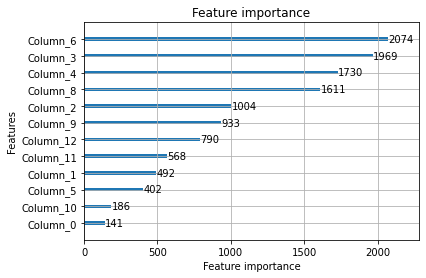

In [ ]:
import lightgbm
lightgbm.plot_importance(lgbm)

In [ ]:
sub_prob.tail(10)

,ID X PCODE,Label
209990,E5UNMF2 X ECY3,0.019720
209991,W5L095K X ECY3,0.021049
209992,8RXBQ1N X ECY3,0.018781
209993,50FTH77 X ECY3,0.003311
209994,9RUOW2K X ECY3,0.020275
209995,0GMU5UH X ECY3,0.023075
209996,I9W11CD X ECY3,0.020007
209997,42WTEGT X ECY3,0.002841
209998,8EKC4O9 X ECY3,0.012082
209999,WHII93K X ECY3,0.022424
